<a href="https://colab.research.google.com/github/Sohankumar6/Final_Project_MRI/blob/main/final_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing required libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomZoom, RandomTranslation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix



In [ ]:
# Creating a base directory and defining the path
base_directory_path = '/content/drive/MyDrive/Final project'
testing_path = base_directory_path + '/Testing'
training_path = base_directory_path + '/Training'


In [ ]:
# Function to count images
def get_images (directory_path):
  '''
  Count and get the images from the directory
  '''
  count_image_dict = {}
  img_paths = []
  img_labels = []
  for class_img_dir in os.listdir(directory_path):
      class_img_path = os.path.join(directory_path, class_img_dir)
      if os.path.isdir(class_img_path):
          count_image_dict[class_img_dir] = len(os.listdir(class_img_path))
          for img_name in os.listdir(class_img_path):
              img_paths.append(os.path.join(class_img_path, img_name))
              img_labels.append(class_img_dir)
  return count_image_dict, img_paths, img_labels


In [ ]:
# Counting the number of images in each class
training_count, training_img_paths, training_label = get_images (training_path)
testing_count, testing_image_paths, testing_label = get_images (testing_path)


In [ ]:
# Converting to dataframe
training_data_df = pd.DataFrame(list(training_count.items()), columns=['Tumor Type', 'Training Count'])
testing_data_df = pd.DataFrame(list(testing_count.items()), columns=['Tumor Type', 'Testing Count'])

In [ ]:
# Merge the training and testing dataframe on tumor type
combined_data_df = pd.merge(training_data_df, testing_data_df, on='Tumor Type')
combined_data_df.set_index('Tumor Type', inplace=True)

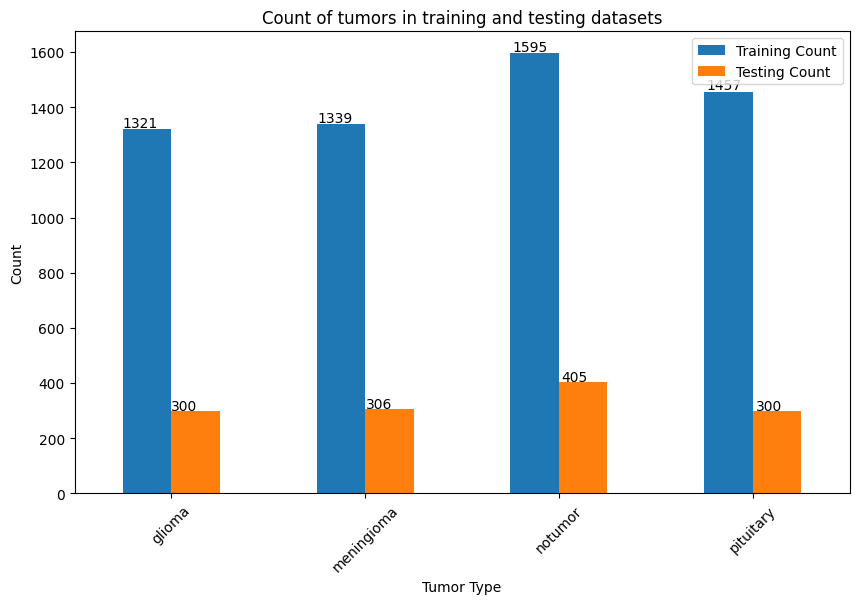

In [ ]:
# Plot the counts on a bar graph
axes = combined_data_df.plot(kind='bar', figsize=(10, 6))
plt.title('Count of tumors in training and testing datasets')
plt.xlabel('Tumor Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
for p in axes.patches:
    axes.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()


In [ ]:
# Creating a class mapping
unique_names = list(set(training_label))
class_naming = {label: idx for idx, label in enumerate(unique_names)}

# Converting labels to indices
training_label_indx = [class_naming[label] for label in training_label]
testing_label_indx = [class_naming[label] for label in testing_label]

In [ ]:
# Function to display images
def show_img(path, label_indx, class_naming, index_list=range(10), img_size=250, figsize=(12, 8)):
    num_img = len(index_list)
    rows = (num_img + 3) // 4
    indx_to_class = {v: k for k, v in class_naming.items()}
    _, axes = plt.subplots(nrows=rows, ncols=4, figsize=figsize)
    axes = axes.flatten()

    for i, index in enumerate(index_list):
        if i >= num_img or index >= len(path):
            axes[i].axis('off')
            continue
        image = load_img(path[index], target_size=(img_size, img_size), color_mode='grayscale')
        axes[i].imshow(image, cmap='Greys_r')
        class_name = indx_to_class[label_indx[index]]
        axes[i].set_title(f'{index}: {class_name}')
        axes[i].axis('off')

    for j in range(num_img, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

combined = list(zip(training_img_paths, training_label_indx))
random.shuffle(combined)
training_img_paths, training_label_indx = zip(*combined)

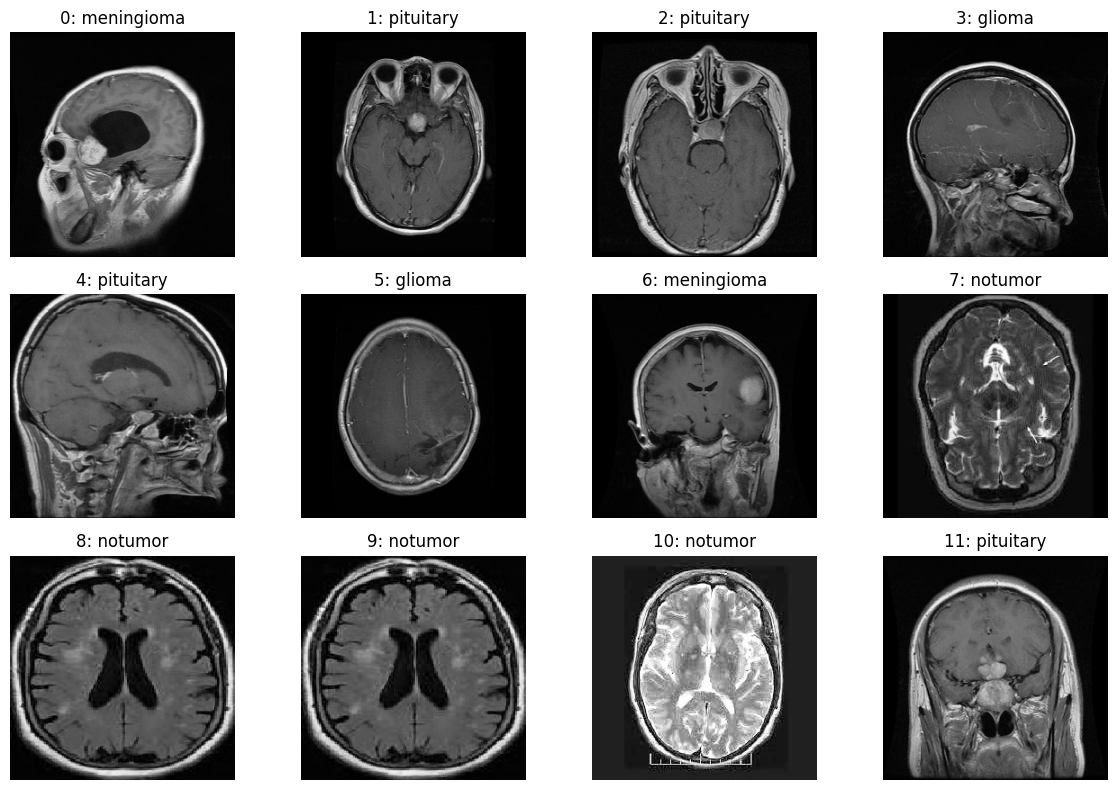

In [ ]:
# Displaying the training images with their labels
show_img(training_img_paths, training_label_indx, class_naming, index_list=range(12))


In [ ]:
# Data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Image dimensions
image_dim = (250, 250)

In [ ]:
# Converting lists to numpy arrays
training_img_paths = np.array(training_img_paths)
training_label_indx = np.array(training_label_indx)
testing_img_paths = np.array(testing_image_paths)
testing_label_indx = np.array(testing_label_indx)


In [ ]:
# Creating TensorFlow dataset from image paths and labels
train_ds = tf.data.Dataset.from_tensor_slices((training_img_paths, training_label_indx))
train_ds = train_ds.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((testing_image_paths, testing_label_indx))
test_ds = test_ds.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch datasets
train_ds_preprocessed = train_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
# Function to display augmented images
def plot_augmented_images(dataset, shape, class_naming, figsize=(15, 6)):
    plt.figure(figsize=figsize)
    indx_to_class = {v: k for k, v in class_naming.items()}
    for images, label in dataset.take(1):
        i = 0
        for i in range(shape[0]*shape[1]):
            axes = plt.subplot(shape[0], shape[1], i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.title(indx_to_class[label.numpy()[i]])
            plt.axis("off")
            i += 1

    plt.tight_layout()
    plt.show()

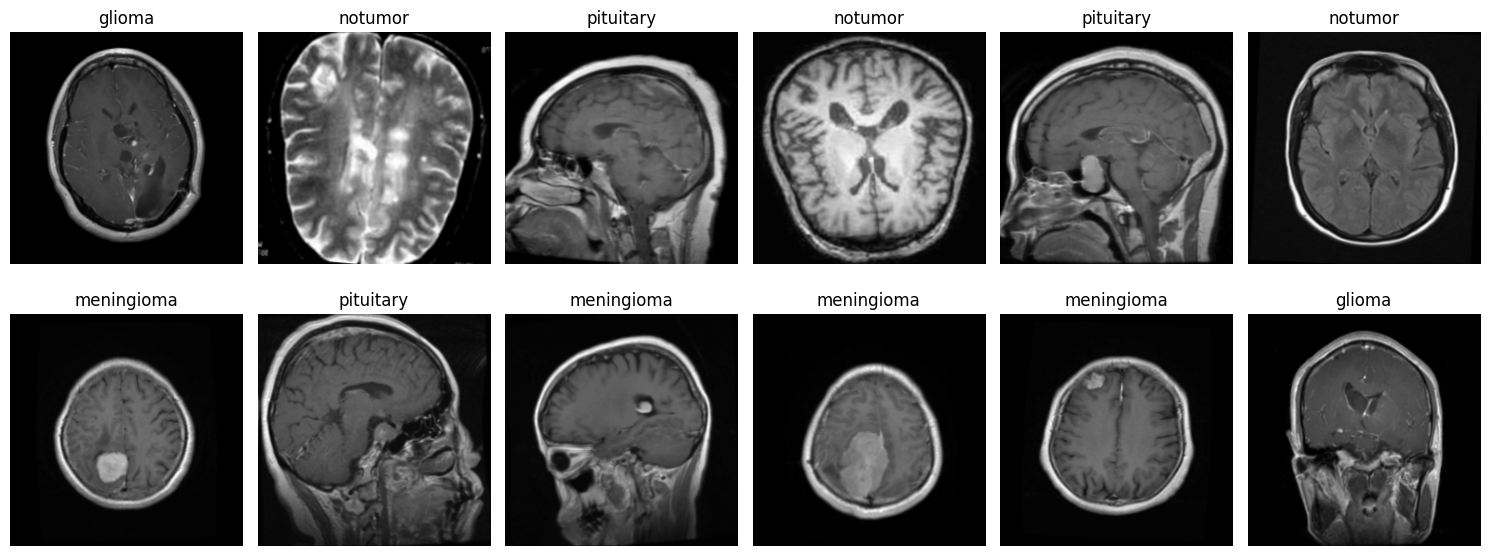

In [ ]:
# Displaying augmented training images
plot_augmented_images(train_ds_preprocessed, shape=(2, 6), class_naming=class_naming)


In [ ]:
num_classes = len(class_naming.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {128}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

inv_class_naming = {v: k for k, v in class_naming.items()}
print(f'Inverse class mappings: {inv_class_naming}')

Number of Classes: 4
Image shape: (250, 250, 1)
Epochs: 50
Batch size: 128
Inverse class mappings: {0: 'notumor', 1: 'pituitary', 2: 'meningioma', 3: 'glioma'}


In [ ]:
# Image dimensions updated
image_dim = (168, 168)

# Batch size updated
batch_size = 32

# Creating a function to preprocess images and labels
def preprocess_image(image_path, label, image_dim, is_train=True):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, image_dim)
    image = image / 255.0

    if is_train:
        image = data_augmentation(image)

    return image, label


In [ ]:
# Data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Function to encode labels
def encode_labels(image, label, num_classes):
    return image, tf.one_hot(label, depth=num_classes)


In [ ]:
# Creating TensorFlow dataset from image paths and labels
train_ds = tf.data.Dataset.from_tensor_slices((training_img_paths, training_label_indx))
train_ds = train_ds.map(lambda x, y: preprocess_image(x, y, image_dim, is_train=True), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(lambda x, y: encode_labels(x, y, num_classes), num_parallel_calls=tf.data.AUTOTUNE)
train_ds_preprocessed = train_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((testing_img_paths, testing_label_indx))
test_ds = test_ds.map(lambda x, y: preprocess_image(x, y, image_dim, is_train=False), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: encode_labels(x, y, num_classes), num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
# Defining the CNN model
def create_model(input_shape, num_classes):

    model = Sequential([
        Input(shape=input_shape),
        Conv2D(64, (5, 5), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(64, (5, 5), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(128, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    return model


In [ ]:
# Model parameters
input_shape = (image_dim[0], image_dim[1], 1)

# Create and compile the model
model = create_model(input_shape, num_classes)
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Define callbacks
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds
        self.factor = factor
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history = model.fit(
    train_ds_preprocessed,
    epochs=50,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc, lr_callback],
    verbose=True
)

# Load the best model
model = load_model('model.keras')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_accuracy*100:.4f}%")


Epoch 1/50
179/179 [==============================] - 220s 1s/step - loss: 0.8660 - accuracy: 0.6303 - val_loss: 0.9360 - val_accuracy: 0.6445 - lr: 0.0010
Epoch 2/50
179/179 [==============================] - 10s 56ms/step - loss: 0.4688 - accuracy: 0.8249 - val_loss: 0.4991 - val_accuracy: 0.7979 - lr: 0.0010
Epoch 3/50
179/179 [==============================] - 10s 55ms/step - loss: 0.3090 - accuracy: 0.8848 - val_loss: 0.4009 - val_accuracy: 0.8513 - lr: 0.0010
Epoch 4/50
179/179 [==============================] - 10s 55ms/step - loss: 0.2282 - accuracy: 0.9146 - val_loss: 0.4167 - val_accuracy: 0.8452 - lr: 0.0010
Epoch 5/50
179/179 [==============================] - 10s 56ms/step - loss: 0.1862 - accuracy: 0.9349 - val_loss: 0.1998 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/50
179/179 [==============================] - 10s 56ms/step - loss: 0.1526 - accuracy: 0.9489 - val_loss: 0.2051 - val_accuracy: 0.9382 - lr: 0.0010
Epoch 7/50
179/179 [==============================] - 10s 5

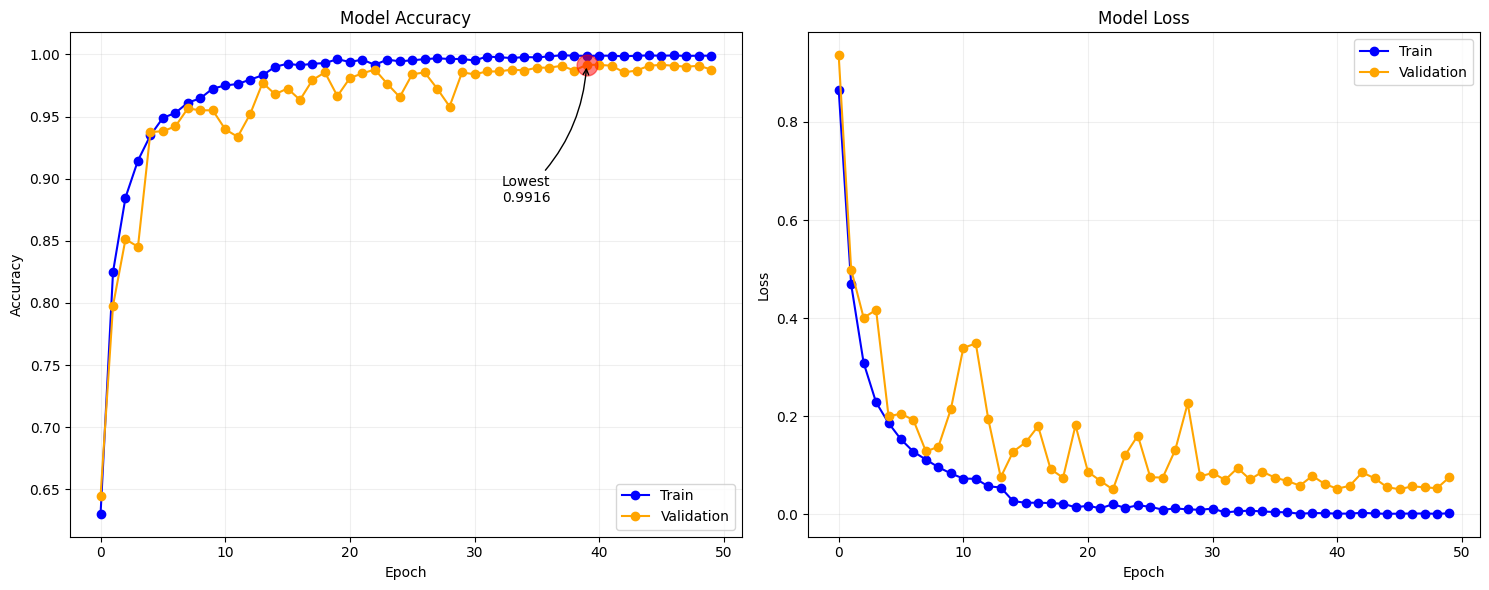

In [ ]:
_, axes = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation accuracy over epochs
axes[0].plot(history.history['accuracy'], marker='o', linestyle='-', color='blue')
axes[0].plot(history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Validation'], loc='lower right')
axes[0].grid(alpha=0.2)

# Plotting training and validation loss over epochs
axes[1].plot(history.history['loss'], marker='o', linestyle='-', color='blue')
axes[1].plot(history.history['val_loss'], marker='o', linestyle='-', color='orange')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Validation'], loc='upper right')
axes[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(history.history['val_accuracy'])
min_val_acc = np.max(history.history['val_accuracy'])
axes[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
axes[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc),
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

In [33]:
# Using test data for preductions
true_labels = []
predicted_labels = []

# Iterate over dataset to collect predictions and true labels and Unbatch to get sample-wise prediction
for images, labels in test_ds_preprocessed.unbatch():
    # Store true labels (Convert one-hot to index)
    true_label = np.argmax(labels.numpy())
    true_labels.append(true_label)

    # Model prediction
    pred = model.predict(tf.expand_dims(images, 0), verbose=False)
    predicted_label = np.argmax(pred)
    predicted_labels.append(predicted_label)

In [35]:
def plot_confusion_matrix(true_labels, predicted_labels, class_naming, metrics=False, cmap='Blues'):
    # Computing confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Mapping of indices to class names in class_naming
    plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=class_naming.keys(), ha='center')
    plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=class_naming.keys(), va='center')
    plt.show()

    if metrics:
        # Precision, Recall, and F1-Score for each class & Overall accuracy
        precision = np.diag(cm) / np.sum(cm, axis=0)
        recall = np.diag(cm) / np.sum(cm, axis=1)
        f1_scores = 2 * precision * recall / (precision + recall)
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)

        print("Class-wise metrics:")
        for i in range(len(class_naming)):
            class_name = list(class_naming.keys())[i]
            print(f"\033[94mClass: {class_name}\033[0m")
            print(f"Precision: {precision[i]:.4f}")
            print(f"Recall: {recall[i]:.4f}")
            print(f"F1-Score: {f1_scores[i]:.4f}\n")

        print(f"\033[92mOverall Accuracy: {accuracy:.4f}\033[0m")

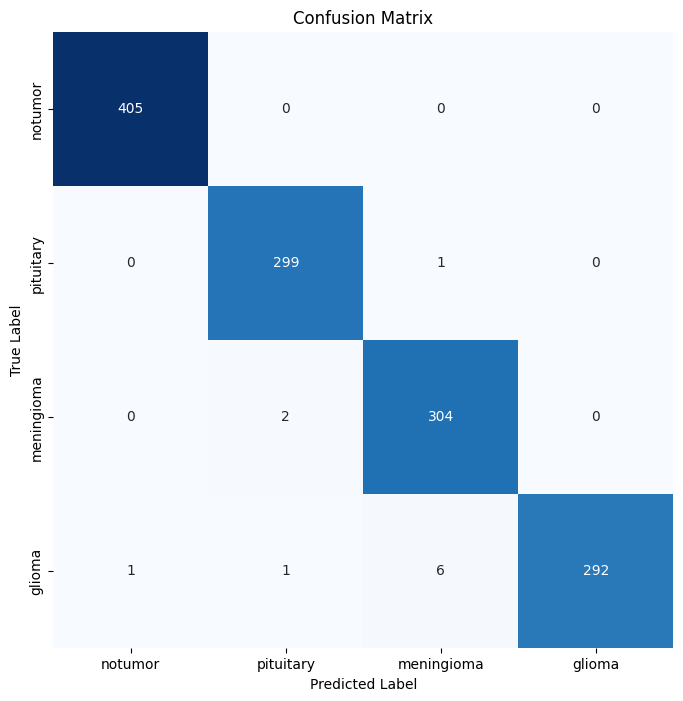

Class-wise metrics:
Class: notumor
Precision: 0.9975
Recall: 1.0000
F1-Score: 0.9988

Class: pituitary
Precision: 0.9901
Recall: 0.9967
F1-Score: 0.9934

Class: meningioma
Precision: 0.9775
Recall: 0.9935
F1-Score: 0.9854

Class: glioma
Precision: 1.0000
Recall: 0.9733
F1-Score: 0.9865

Overall Accuracy: 0.9916


In [36]:
# Confusion matrix and netrics from predictions
plot_confusion_matrix(true_labels,
                      predicted_labels,
                      class_naming,
                      metrics=True)

In [37]:
# Plots sample predictions from the model
def plot_sample_predictions(model, dataset, indx_to_class, num_samples=9, figsize=(13, 12)):
    print('inside')
    plt.figure(figsize=figsize)
    rows = num_cols = int(np.sqrt(num_samples))
    print('rows', rows)

    iterator = iter(dataset.unbatch())

    for i in range(1, num_samples + 1):
        print('inside the loop')
        image, true_label = next(iterator)
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        print(predictions)
        predicted_label = np.argmax(predictions, axis=1)[0]

        true_class_index = np.argmax(true_label.numpy())
        true_class = indx_to_class[true_class_index]
        predicted_class = indx_to_class[predicted_label]

        # Determine title color based on prediction accuracy
        title_color = 'green' if true_class_index == predicted_label else 'red'

        plt.subplot(rows, num_cols, i)
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.title(f"True: {true_class}\nPred: {predicted_class}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

inside
rows 3
inside the loop
[[1.6139306e-14 1.0000000e+00 4.6903409e-08 3.2438215e-11]]
inside the loop
[[9.1214525e-14 1.0000000e+00 2.0228444e-10 7.2369470e-13]]
inside the loop
[[3.2103026e-14 1.0000000e+00 1.1612646e-11 3.3697874e-11]]
inside the loop
[[1.5272066e-20 1.0000000e+00 3.1523109e-12 2.7619362e-19]]
inside the loop
[[6.0131483e-11 1.0017043e-03 9.9899834e-01 2.6057528e-10]]
inside the loop
[[2.8387286e-18 1.0000000e+00 5.3134137e-08 1.8300077e-12]]
inside the loop
[[2.8367521e-15 1.0000000e+00 1.4045556e-09 1.0919470e-09]]
inside the loop
[[4.3301462e-18 1.0000000e+00 4.3885407e-14 2.6611639e-15]]
inside the loop
[[7.5532026e-17 1.0000000e+00 1.2253758e-14 8.6081042e-19]]


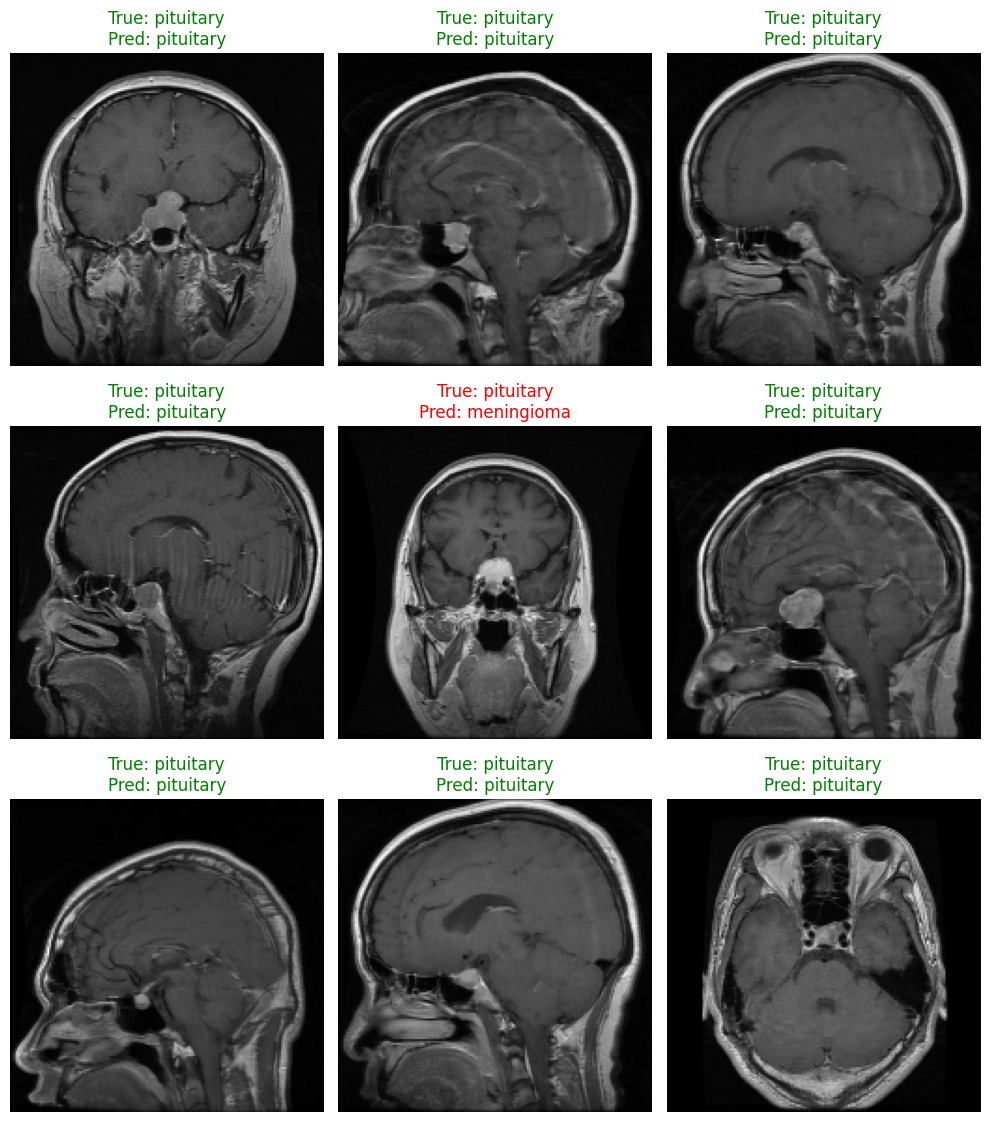

In [38]:
# Plottinng samples with predictions
plot_sample_predictions(model=model,
                        dataset=test_ds_preprocessed,
                        indx_to_class=inv_class_naming,
                        num_samples=9,
                        figsize=(10, 11.5))

In [39]:
# Function to plots misclassified samples from the dataset
def plot_misclassified_samples(model, dataset, indx_to_class, figsize=(10, 10)):
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    # Iterate over dataset to collect misclassified images
    for image, true_label in dataset.unbatch():
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]
        true_class_index = np.argmax(true_label.numpy())

        if true_class_index != predicted_label:
            misclassified_images.append(image.numpy().squeeze())
            misclassified_labels.append(indx_to_class[true_class_index])
            misclassified_predictions.append(indx_to_class[predicted_label])

    # Determine number of rows and columns for subplot
    num_misclassified = len(misclassified_images)
    cols = int(np.sqrt(num_misclassified)) + 1
    rows = num_misclassified // cols + (num_misclassified % cols > 0)

    # Plotting misclassified images
    miss_classified_zip = zip(misclassified_images, misclassified_labels, misclassified_predictions)
    plt.figure(figsize=figsize)
    for i, (image, true_label, predicted_label) in enumerate(miss_classified_zip):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color='red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

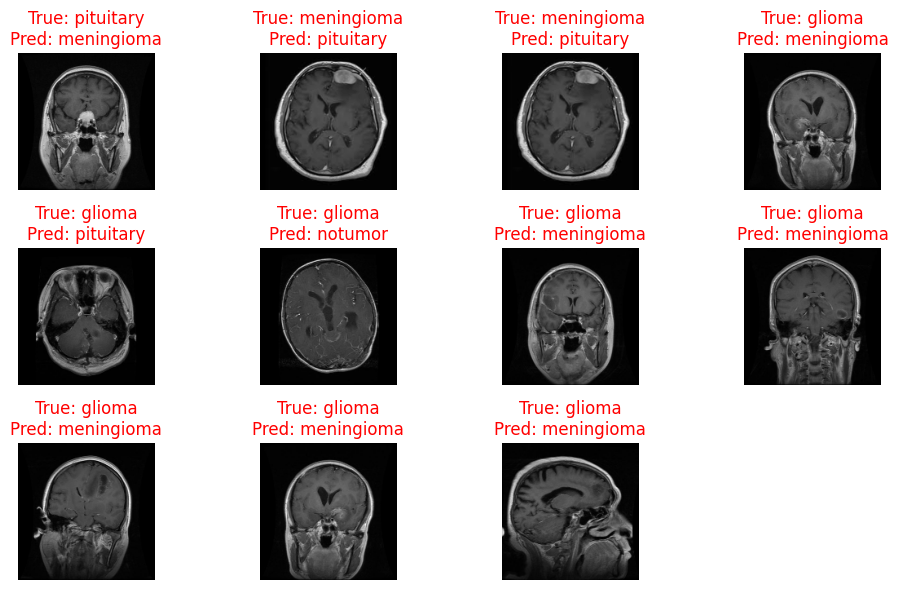

In [40]:
plot_misclassified_samples(model=model,
                           dataset=test_ds_preprocessed,
                           indx_to_class=inv_class_naming,
                           figsize=(10, 6))

In [41]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
